In [1]:
from gptopt.optim.attn_kq import *
from utils import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

In [3]:
n_layer = 4
std1 = 1 #0.02 / np.sqrt(2.0 * n_layer)
std2 = 1 #0.01
rank_ratio = 0.7
max_iter = 500

mu_scales = [0.1, 0.05]
beta = 0.01

In [4]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

#  $m=768, ~n=64, ~h=12$

In [5]:
m = 768
n_head = 12
n = 64 * n_head

In [6]:
A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)

mu_max = (A_linop.matvec(Grad)).abs().max().item() / beta 
lamb_max = A_linop.fro_norm

print(f"{lamb_max=:.4e}, {mu_max=:.4e}")

lamb_max=1.0873e+03, mu_max=1.6544e+03


In [7]:
residuals = {}
for mu_scale in mu_scales:
    mu_reg = max(mu_scale * mu_max, 1e-6)
    residuals[mu_scale] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter)

Method                 Obj          Viol
----------------------------------------
pdhg          -7.653319e+01  2.584086e-01
rehpdhg       -8.449834e+01  8.670678e-01
pdhg ds       -7.713843e+01  3.510699e-01
rehpdhg ds    -8.572714e+01  9.778835e-01
fista         -7.529933e+01  5.917444e-02
Method                 Obj          Viol
----------------------------------------
pdhg          -8.353609e+01  1.299292e-01
rehpdhg       -9.596442e+01  9.323381e-01
pdhg ds       -8.389500e+01  1.823640e-01
rehpdhg ds    -9.772906e+01  1.053262e+00
fista         -8.296352e+01  1.293098e-01


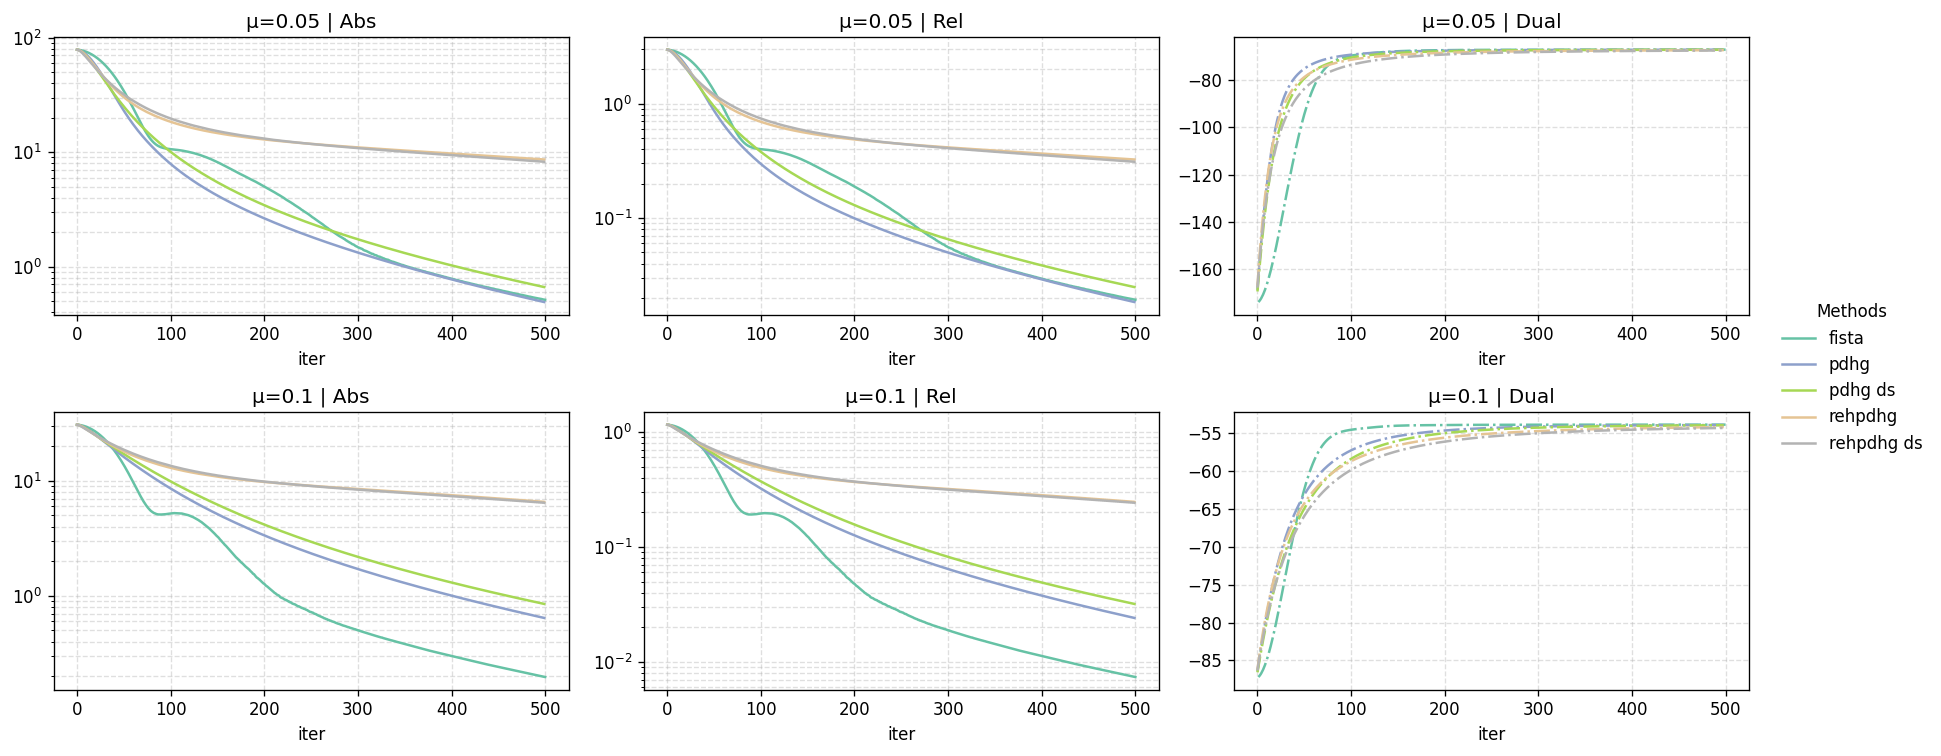

In [8]:
_ = plot_residuals_grid_by_param(residuals, param_name='mu')